# Inversion example of the diffusion

- Import required packages

In [1]:
import os
import logging
import copy
from pathlib import Path
from typing import Generator
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
from matplotlib.animation import HTMLWriter
from IPython.display import HTML
import nested_grid_plotter as ngp
import pyrtid
import pyrtid.forward as dmfwd
import pyrtid.inverse as dminv
from pyrtid.inverse.regularization import (
    TikhonovRegularizator,
    TVRegularizator,
)
from pyrtid.utils import GaussianFilter, NDArrayFloat
import numpy as np

- Check package/software versions

In [2]:
pyrtid.utils.show_versions()

pyrtid.__version__ = 0.1.0
nested_grid_plotter.__version__ = 0.1.0


- Create a directory to store the exported figures

In [4]:
ipynb_path = os.path.dirname(os.path.realpath("__file__"))
fig_save_path = Path(ipynb_path, "exported_figures")
fig_save_path.mkdir(parents=True, exist_ok=True)  # make sure that the directory exists

- Set-up logging level

In [5]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.info("this is a test")

INFO:root:this is a test


- Define some configurations for the plots

In [6]:
# Some configs for the plots
new_rc_params = {
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica", "DejaVu Sans"],
    "font.size": 16,
    "text.usetex": False,
    "savefig.format": "svg",
    "svg.fonttype": "none",  # to store text as text, not as path
    "savefig.facecolor": "w",
    "savefig.edgecolor": "k",
    "savefig.dpi": 300,
    "figure.constrained_layout.use": True,
    "figure.facecolor": "w",
    "axes.facecolor": "w",
}
csfont = {"fontname": "Comic Sans MS"}
hfont = {"fontname": "Helvetica"}
plt.plot()
plt.close()  # required for the plot to update
plt.rcParams.update(new_rc_params)

## Forward problem

Let's define a very simple pure diffusion case in 1D.

In [7]:
# time_params = dmfwd.TimeParameters(nt=1000, dt_init=4000.0)
time_params = dmfwd.TimeParameters(
    duration=duration_in_s, dt_init=dt_init, dt_max=dt_max, dt_min=dt_min
)
geometry = dmfwd.Geometry(nx=21, ny=1, dx=10.0, dy=10.0)
fl_params = dmfwd.FlowParameters(permeability=1e-10)
tr_params = dmfwd.TransportParameters(diffusion=1e-4, porosity=0.23)
gch_params = dmfwd.GeochemicalParameters(conc=0.0, grade=0.0)


# We define a function to easily generate a model.
def create_base_model() -> dmfwd.ForwardModel:
    return dmfwd.ForwardModel(geometry, time_params, fl_params, tr_params, gch_params)

- x_coordinates array for the plots

In [8]:
x_coordinates = (np.arange(geometry.nx) + 0.5) * geometry.dx

- Time for the plots

In [9]:
times_in_days = np.arange(time_params.nt) * time_params.dt / 3600 / 24  # in days

- Create two identical model

In [10]:
model_reference = create_base_model()
model_estimate = create_base_model()

- One with a constant diffusion (initial guess), the other with a bumped coefficient (reference)

In [11]:
model_reference.tr_model.diffusion[6:12, 0] = 1e-3
model_estimate.tr_model.diffusion[:, :] = 1.5e-4

- The initial aqueous concentration of the tracer is the same -> a bump

In [12]:
model_reference.tr_model.conc[10:14, 0] = 0.01  # [mol/kg]
model_estimate.tr_model.conc[10:14, 0] = 0.01  # [mol/kg]

- Plot it

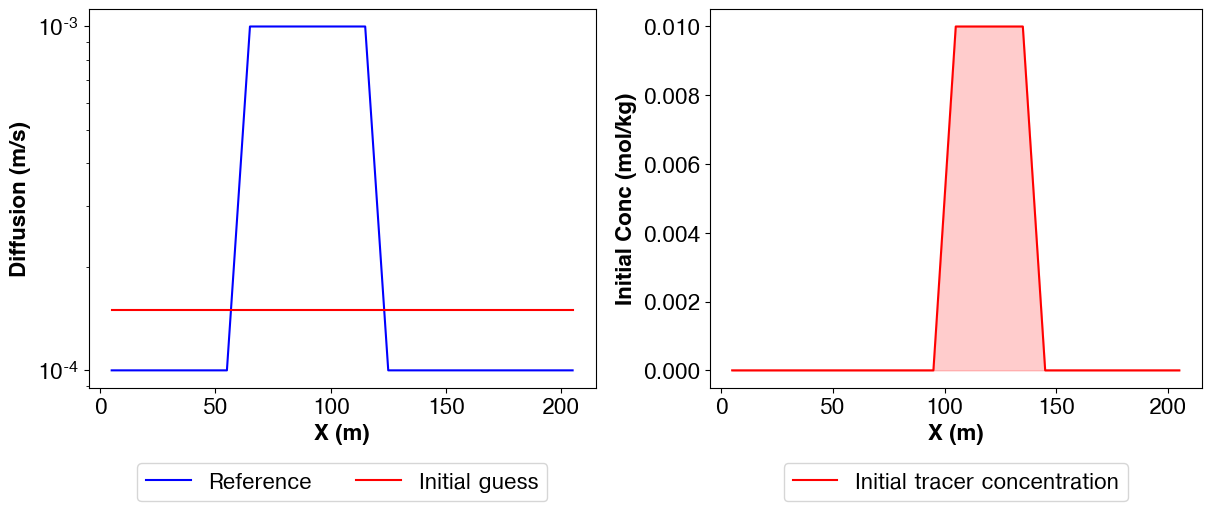

In [13]:
plotter = ngp.NestedGridPlotter(
    fig_params={"figsize": (12, 5)}, subfigs_params={"ncols": 2}
)
ax1 = plotter.ax_dict["ax1-1"]
ax1.plot(
    x_coordinates, model_reference.tr_model.diffusion[:, 0], label="Reference", c="b"
)
ax1.plot(
    x_coordinates, model_estimate.tr_model.diffusion[:, 0], label="Initial guess", c="r"
)
ax1.set_yscale("log")
ax1.legend(ncol=2, loc="center", bbox_to_anchor=(0.5, -0.25))
ax1.set_xlabel("X [m]", fontweight="bold")
ax1.set_ylabel("Diffusion (m/s)", fontweight="bold")

ax2 = plotter.ax_dict["ax1-2"]
ax2.plot(
    x_coordinates,
    model_reference.tr_model.conc[:, 0, 0],
    label="Initial tracer concentration",
    color="red",
)
ax2.fill_between(
    x_coordinates,
    0.0,
    model_reference.tr_model.conc[:, 0, 0],
    alpha=0.2,
    color="red",
)
ax2.set_xlabel("X [m]", fontweight="bold")
ax2.set_ylabel("Initial Conc (mol/kg)", fontweight="bold")
ax2.legend(loc="center", bbox_to_anchor=(0.5, -0.25))
plotter.fig.patch.set_facecolor("w")

We can then run these too models and compare the results

In [14]:
solver_reference = dmfwd.ForwardSolver(model_reference)
solver_reference.solve()

solver_estimate = dmfwd.ForwardSolver(model_estimate)
solver_estimate.solve()

ValueError: dimension mismatch

We can disply the results in different ways.

In [ ]:
# Let's create a 3D plotter to visualize the results
plotter_3d = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (9, 4.5)},
    subfigs_params={"ncols": 2},
    subplots_mosaic_params={
        "true": {"mosaic": [["ax11"]], "subplot_kw": {"projection": "3d"}},
        "estimate": {"mosaic": [["ax12"]], "subplot_kw": {"projection": "3d"}},
    },
)
plotter_3d.fig.patch.set_facecolor("w")

data = solver_reference.model.tr_model.conc[:, 0, :]
X, Y = np.meshgrid(x_coordinates, np.arange(data.shape[1]))
ax = plotter_3d.ax_dict["ax11"]
ax.plot_surface(X, Y, data.T, cmap=plt.cm.coolwarm)
# Inverse the time axis to get a better dislay
ax.set_ylim(reversed(ax.get_ylim()))
plotter_3d.subfigs["true"].suptitle("True")
ax.set_xlabel("X [m]", fontweight="bold")
ax.set_ylabel("Timestep #", fontweight="bold")
ax.set_zlabel("Tracer concentration [molal]")

data = solver_estimate.model.tr_model.conc[:, 0, :]
ax = plotter_3d.ax_dict["ax12"]
ax.plot_surface(X, Y, data.T, cmap=plt.cm.coolwarm, alpha=0.9)
# Inverse the time axis to get a better dislay
ax.set_xlabel("X [m]", fontweight="bold")
ax.set_ylabel("Timestep #", fontweight="bold")
ax.set_ylim(reversed(ax.get_ylim()))
plotter_3d.subfigs["estimate"].suptitle("Estimate")

- Top view

In [ ]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (10, 6)},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[["ax1-1"], ["ax2-1"]],
            sharey=True,
            sharex=True,
        )
    },
)

ngp.multi_imshow(
    axes=list(plotter.ax_dict.values()),
    fig=plotter.fig,
    data={
        "True model demonstrator": solver_reference.model.tr_model.conc[:, 0, :].T,
        "A priori (estimate) model demonstartor": solver_estimate.model.tr_model.conc[
            :, 0, :
        ].T,
    },
    xlabel="Time (d)",
    ylabel="X [m]",
    imshow_kwargs=dict(
        extent=(
            0.0,
            time_params.nt * time_params.dt / 3600 / 24,
            x_coordinates[0],
            x_coordinates[-1],
        )
    ),
)

fname = "tracer_concentration_true_vs_estimate_map"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

- Consider three observation locations

In [ ]:
observation_locations = [6, 10, 15]

In [ ]:
plotter = ngp.AnimatedPlotter(
    fig_params={"constrained_layout": True, "figsize": (6, 5)},
)

ax = plotter.get_axis("ax1-1")
ax.plot(x_coordinates, model_reference.tr_model.conc[:, 0, 0], c="red", label="Initial")

# Animated plot
nb_frames = 30

plotter.animated_multi_plot(
    ax_name="ax1-1",
    data={
        "True": {
            "x": x_coordinates,
            "y": model_reference.tr_model.conc[:, 0, :],
            "kwargs": {"c": "blue"},
        },
        "Estimated": {
            "x": x_coordinates,
            "y": model_estimate.tr_model.conc[:, 0, :],
            "kwargs": {"c": "green", "linestyle": "--"},
        },
    },
    nb_frames=nb_frames,
    title="Demonstrator conc",
    xlabel="X [m]",
)


# plot the time
def get_time() -> Generator[str, None, None]:
    ts_btw_frames = int(time_params.dt * time_params.nt / nb_frames)
    for frame in range(nb_frames):
        yield f"time = {ts_btw_frames * frame / 3600:.2f} h"


# Add some vertical lines to indicate the well
for well_pos in observation_locations:
    # handle = plotter.ax_dict["ax1-1"].axvline(
    #     x=well_pos, linestyle="--", line
    # )
    # plotter.add_extra_legend_item("ax1-1", handle, "hm_end_time")
    ax.plot(
        (well_pos + 0.5) * geometry.dx,
        0.0002,
        label="obs wells",
        marker="^",
        markersize=10,
        c="r",
        linestyle="none",
    )

plotter.plot_animated_text(
    ax=ax,
    x=0.83,
    y=0.92,
    s=list(get_time()),
    horizontalalignment="center",
    verticalalignment="center",
    transform=ax.transAxes,
    fontsize=14,
    fontweight="bold",
)
plotter.add_axis_legend("ax1-1")

plotter.close()
plotter.animate(nb_frames=nb_frames)
# Save the animation locally on the computer
fname_html = fig_save_path.joinpath("true_vs_estimate_conc_animation.html")
writer = HTMLWriter(fps=5, embed_frames=True)
writer.frame_format = "svg"  # Ensure svg format
plotter.animation.save(str(fname_html), writer=writer)

# Extract the svg from the html file (for animation in Latex)
ngp.extract_frames_from_embedded_html_animation(fname_html)

# Display the animation
HTML(fname_html.read_text())

Let's now consider that we have some observation wells. We can plot what the observation well would sample in both cases and see the difference. Let's place three wells at positions `65m`, `105m` and `155m` (at the center of the nodes).

In [ ]:
from typing import List, Tuple


def polygon_under_graph(x: np.ndarray, y: np.ndarray) -> List[Tuple[float, float]]:
    """
    Construct the vertex list which defines the polygon filling the space under
    the (x, y) line graph. This assumes x is in ascending order.
    """
    return [(x[0], 0.0), *zip(x, y), (x[-1], 0.0)]


well_pos = (np.array(observation_locations) + 0.5) * geometry.dx
time_dim = model_reference.tr_model.conc.shape[2]
z_max = model_reference.tr_model.conc.max()
y = np.arange(time_dim)
z = np.ones(time_dim) * z_max

# verts[i] is a list of (x, y) pairs defining polygon i.
verts = [polygon_under_graph(y, z)] * len(well_pos)

poly1 = PolyCollection(verts, facecolors="g", alpha=0.2, zorder=10)
poly2 = PolyCollection(verts, facecolors="g", alpha=0.2, zorder=10)
plotter_3d.ax_dict["ax11"].add_collection3d(poly1, zs=well_pos, zdir="x")
plotter_3d.ax_dict["ax12"].add_collection3d(poly2, zs=well_pos, zdir="x")

for node_id in well_pos:
    x = [node_id] * 2
    y = [model_reference.tr_model.conc.shape[2]] * 2
    z = (0.0, z_max)

    plotter_3d.ax_dict["ax11"].plot(
        x, y, z, label="parametric curve", linewidth=3.0, zorder=10, c="g"
    )
    plotter_3d.ax_dict["ax12"].plot(
        x, y, z, label="parametric curve", linewidth=3.0, zorder=10, c="g"
    )

plotter_3d.fig

- Create a function to add some noise to the observations (limit the inverse crime)

In [ ]:
noise_std = 1e-4  # This is an absolute value
rng = np.random.default_rng(2021)


def make_noisy(x: NDArrayFloat) -> NDArrayFloat:
    """Return the input with some added white noise.

    Note
    ----
    The parameters are hardcoded to be consistent in the notebook.
    Change the function directly.
    """
    mean_noise = 0.0  # mean
    return x + rng.normal(mean_noise, noise_std, x.shape)

- Plot what it gives at the well level

In [ ]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (8, 8)},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[["ax1-1"], ["ax2-1"], ["ax3-1"]], sharey=False, sharex=True
        )
    },
)

for i, node_id in enumerate(observation_locations):
    ax = plotter.get_axis(f"ax{i + 1}-1")
    x = (node_id + 0.5) * geometry.dx
    obs_well_name = f"obs. well @ node #{node_id} (x={x}m)"

    ax.set_title(obs_well_name)
    ax.plot(
        times_in_days,
        model_reference.tr_model.conc[node_id, 0, :],
        label="Reference",
        c="b",
    )
    ax.plot(
        times_in_days,
        make_noisy(model_reference.tr_model.conc[node_id, 0, :]),
        marker="o",
        linestyle="None",
        label="Noisy reference",
        c="b",
        alpha=0.2,
    )
    ax.plot(
        times_in_days,
        model_estimate.tr_model.conc[node_id, 0, :],
        label="A priori",
        c="r",
    )

plotter.fig.supxlabel("Time (d)", fontweight="bold")
plotter.fig.supylabel("Concentration (mol/kg)", fontweight="bold")
plotter.fig.suptitle("Tracer at obs wells", fontweight="bold")
plotter.add_fig_legend(ncol=2, bbox_y_shift=0.02)

fname = "tracer_concentration_true_vs_estimate_at_obs_1D"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

## Inversion

### Gradient verification with finite difference

Inversion with three wells. Let's first check if the gradient with ths adjoint state method is correct.

In [ ]:
param = AdjustableParameter(
    name=ParameterName.DIFFUSION,
    lbounds=2e-5,
    ubounds=5e-3,
    preconditioner=dminv.LogTransform(),
)

observables = {}
for node_id in [6, 10, 15]:
    vals = model_reference.tr_model.conc[node_id, 0, :]
    timesteps = np.arange(vals.shape[0])

    observables[node_id] = Observable(
        state_variable=StateVariable.CONCENTRATION,
        location=(slice(node_id, node_id + 1, 1), slice(None)),
        timesteps=timesteps,
        values=vals,
        uncertainties=noise_std,
    )

# Create an executor to keep track of the adjoint model
solver_config = ScipySolverConfig(
    solver_name="L-BFGS-B",
    solver_options={"maxfun": 20, "maxiter": 20, "ftol": 1e-4, "gtol": 1e-4},
    is_check_gradient=True,
)
model_adjusted = copy.deepcopy(model_estimate)
inverse_model = InverseModel(param, list(observables.values()))
executor = ScipyInversionExecutor(model_adjusted, inverse_model, solver_config)

is_grad_ok = executor.is_adjoint_gradient_correct()
print("Is the gradient correct: ", is_grad_ok)

- Plot the approximated gradient vs the adjoint-state based one

In [ ]:
plotter = ngp.NestedGridPlotter()
ax = plotter.get_axis("ax1-1")
ax.plot(
    x_coordinates,
    param.get_gridded_archived_gradients(is_adjoint=True)[:, :, 0],
    label="Adj. Demonstrator",
    c="b",
)
ax.plot(
    x_coordinates,
    param.get_gridded_archived_gradients(is_adjoint=False)[:, :, 0],
    label="FD Demonstrator",
    c="r",
    linestyle="--",
)
ax.set_xlabel("X [m]", fontweight="bold")
ax.set_ylabel("Gradient (preconditioned)", fontweight="bold")
plotter.add_fig_legend(ncol=2)

Plot of the adjoint variables

In [ ]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (8, 4)}
)

ngp.multi_imshow(
    axes=list(plotter.ax_dict.values()),
    fig=plotter.fig,
    data={
        "Adjoint variable": executor.adj_model.a_tr_model.a_conc[:, 0, :].T,
    },
    xlabel="Time (d)",
    ylabel="X [m]",
    imshow_kwargs=dict(
        extent=(
            0.0,
            time_params.nt * time_params.dt / 3600 / 24,
            x_coordinates[0],
            x_coordinates[-1],
        )
    ),
)

fname = "tracer_concentration_true_vs_estimate_map"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

At the observatinon well, we can see that the sign of the adjoint variable globally depends on the sign of the residuals.

In [ ]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (12, 8)},
    subfigs_params={"ncols": 2},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[["ax1-1"], ["ax2-1"], ["ax3-1"]], sharey=False, sharex=True
        ),
        "fig1": dict(
            mosaic=[["ax1-2"], ["ax2-2"], ["ax3-2"]], sharey=False, sharex=True
        ),
    },
)

for i, node_id in enumerate(observation_locations):
    ax = plotter.get_axis(f"ax{i + 1}-1")
    x = (node_id + 0.5) * geometry.dx
    obs_well_name = f"obs. well @ node #{node_id} (x={x}m)"

    ax.set_title(obs_well_name)
    ax.plot(
        times_in_days,
        model_reference.tr_model.conc[node_id, 0, :],
        label="Reference demonstrator",
        c="b",
    )
    ax.plot(
        times_in_days,
        model_estimate.tr_model.conc[node_id, 0, :],
        label="A priori demonstrator",
        c="r",
    )
    ax2 = plotter.get_axis(f"ax{i + 1}-2")
    ax2.set_title(obs_well_name)
    ax2.plot(
        times_in_days,
        executor.adj_model.a_tr_model.a_conc[node_id, 0, :],
        label="A priori demonstrator",
        c="r",
    )

plotter.fig.supxlabel("Time (d)", fontweight="bold")
plotter.subfigs["fig0"].supylabel("Concentration (mol/kg)", fontweight="bold")
plotter.subfigs["fig1"].supylabel("Adjoint concentration", fontweight="bold")
plotter.fig.suptitle("Tracer at obs wells", fontweight="bold")
plotter.add_fig_legend(ncol=2, bbox_y_shift=0.02)

fname = "tracer_concentration_true_vs_estimate_at_obs_1D"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

### First inversion run

In [ ]:
executor.run()

Let's plot the results: evolution of the parameter, the gradient, the objective function.

In [ ]:
plotter = ngp.AnimatedPlotter(
    fig_params={"figsize": (10.0, 8.0)}, subfigs_params={"nrows": 2, "ncols": 2}
)

# 1 frame per solver iteration
nb_frames: int = inverse_model.nb_f_calls

aligned_adjoint_gradients = param.get_gridded_archived_gradients(is_adjoint=True)

# 1) Gradient evolution
plotter.get_axis("ax1-1").plot(
    aligned_adjoint_gradients[:, 0, 0], label="Initial", c="b"
)

plotter.get_axis("ax1-1").set_title("Gradient", fontweight="bold")

xlabel = "Node #"

plotter.animated_multi_plot(
    ax_name="ax1-1",
    data={
        "ADJ": {"y": aligned_adjoint_gradients[:, 0, :], "kwargs": {"c": "g"}},
    },
    nb_frames=nb_frames,
)

plotter.ax_dict["ax1-1"].legend()


# 2) Parameter evolution
plotter.get_axis("ax1-2").plot(
    x_coordinates, model_reference.tr_model.diffusion[:, 0], c="b", label="Reference"
)
plotter.get_axis("ax1-2").plot(
    x_coordinates, model_reference.tr_model.diffusion[:, 0], c="orange", label="Initial"
)

plotter.animated_multi_plot(
    ax_name="ax1-2",
    data={
        "Inverted": {
            "x": x_coordinates,
            "y": np.transpose(np.array(param.archived_values), axes=[1, 2, 0])[:, 0, :],
            "kwargs": {"c": "r", "linestyle": "--"},
        },
    },
    nb_frames=nb_frames,
)
plotter.get_axis("ax1-2").set_title("Diffusivity field", fontweight="bold")
plotter.get_axis("ax1-2").set_xlabel("X [m]")
plotter.get_axis("ax1-2").set_ylabel("[m2/s]")
plotter.ax_dict["ax1-2"].legend()
plotter.ax_dict["ax1-2"].set_yscale("log")

# 3) Objective function
vals = inverse_model.loss_scaled_history
obj_fun_vals = np.full((len(vals), nb_frames), fill_value=np.nan)
for i in range(len(vals)):
    obj_fun_vals[: i + 1, i] = vals[: i + 1]

plotter.animated_multi_plot(
    ax_name="ax2-1",
    data={
        "Obj fun": {"y": obj_fun_vals, "kwargs": {"c": "r", "linestyle": "--"}},
    },
    nb_frames=nb_frames,
    title="Objective function",
    xlabel="Iteration #",
)
plotter.ax_dict["ax2-1"].set_yscale("log")

# 4) Observation vs predicted values
pyrtid.plot.plot_observed_vs_simulated(
    plotter.ax_dict["ax2-2"],
    obs_vector=dminv.get_observables_values_as_1d_vector(list(observables.values()))
    * 1000,
    pred_vector=dminv.get_predictions_matching_observations(
        model_adjusted, list(observables.values())
    )
    * 1000,
    pred_vector_initial=dminv.get_predictions_matching_observations(
        model_estimate, list(observables.values())
    )
    * 1000,
    units="$mmol.l^{-1}$",
)

plotter.close()
plotter.animate(nb_frames=nb_frames)
# Save the animation locally on the computer
fname_html = fig_save_path.joinpath("m_j_g_animation.html")
writer = HTMLWriter(fps=2, embed_frames=True)
writer.frame_format = "svg"  # Ensure svg format
plotter.animation.save(str(fname_html), writer=writer)

# Extract the svg from the html file (for animation in Latex)
ngp.extract_frames_from_embedded_html_animation(fname_html)

# Display the animation
HTML(fname_html.read_text())

In [ ]:
plotter = ngp.AnimatedPlotter(
    fig_params={"constrained_layout": True, "figsize": (6, 5)},
)

ax = plotter.get_axis("ax1-1")
ax.plot(x_coordinates, model_reference.tr_model.conc[:, 0, 0], c="red", label="Initial")

# Animated plot
nb_frames = 30

plotter.animated_multi_plot(
    ax_name="ax1-1",
    data={
        "Reference": {
            "x": x_coordinates,
            "y": model_reference.tr_model.conc[:, 0, :],
            "kwargs": {"c": "blue"},
        },
        "Before-inversion": {
            "x": x_coordinates,
            "y": model_estimate.tr_model.conc[:, 0, :],
            "kwargs": {"c": "orange", "linestyle": "--"},
        },
        "Post-inversion": {
            "x": x_coordinates,
            "y": model_adjusted.tr_model.conc[:, 0, :],
            "kwargs": {"c": "green", "linestyle": "--"},
        },
    },
    nb_frames=nb_frames,
    title="Demonstrator conc",
    xlabel="X [m]",
)


# plot the time
def get_time() -> Generator[str, None, None]:
    ts_btw_frames = int(time_params.dt * time_params.nt / nb_frames)
    for frame in range(nb_frames):
        yield f"time = {ts_btw_frames * frame / 3600:.2f} h"


# Add some vertical lines to indicate the well
for well_pos in observation_locations:
    # handle = plotter.ax_dict["ax1-1"].axvline(
    #     x=well_pos, linestyle="--", line
    # )
    # plotter.add_extra_legend_item("ax1-1", handle, "hm_end_time")
    ax.plot(
        (well_pos + 0.5) * geometry.dx,
        0.0002,
        label="obs wells",
        marker="^",
        markersize=10,
        c="r",
        linestyle="none",
    )

plotter.plot_animated_text(
    ax=ax,
    x=0.83,
    y=0.92,
    s=list(get_time()),
    horizontalalignment="center",
    verticalalignment="center",
    transform=ax.transAxes,
    fontsize=14,
    fontweight="bold",
)
plotter.add_axis_legend("ax1-1")

plotter.close()
plotter.animate(nb_frames=nb_frames)
# Save the animation locally on the computer
fname_html = fig_save_path.joinpath("true_vs_estimate_conc_animation.html")
writer = HTMLWriter(fps=5, embed_frames=True)
writer.frame_format = "svg"  # Ensure svg format
plotter.animation.save(str(fname_html), writer=writer)

# Extract the svg from the html file (for animation in Latex)
ngp.extract_frames_from_embedded_html_animation(fname_html)

# Display the animation
HTML(fname_html.read_text())

# Impact of the gradient smoothing

To facilitate convergence and avoid falling into local minima, a trick is to smooth the gradient during the first iterations. In this way, the adjustment will be done on the main trends at first, then more locally in a second time.

In [ ]:
param_with_gradient_smoothing = AdjustableParameter(
    name=ParameterName.DIFFUSION,
    lbounds=2e-5,
    ubounds=5e-3,
    preconditioner=dminv.LogTransform()
    filters=[GaussianFilter(sigmas=[1.5, 1.5, 1.0, 0.5, 0.25])],
)

model_adjusted = copy.deepcopy(model_estimate)
inverse_model2 = InverseModel(param, list(observables.values()))
executor = ScipyInversionExecutor(model_adjusted, inverse_model2, solver_config)

executor.run()

Let's compare the objective functions with and without

In [ ]:
fig, ax = plt.subplots()

ax.plot(
    inverse_model.loss_scaled_history, c="r", linestyle="--", label="Without smoother"
)
ax.plot(
    inverse_model2.loss_scaled_history, c="b", linestyle="--", label="With smoother"
)

ax.set_title("Objective function")
ax.set_xlabel("Iteration #")
ax.set_yscale("log")

# Impact of the regularization

We create three different models:
- The first without regularization
- The second with a tickonov regularization
- The third with a TV regularization

In [ ]:
param_no_reg = AdjustableParameter(
    name=ParameterName.DIFFUSION,
    lbounds=2e-5,
    ubounds=5e-3,
    preconditioner=dminv.LogTransform()
)

param_reg_tikhonov = AdjustableParameter(
    name=ParameterName.DIFFUSION,
    lbounds=2e-5,
    ubounds=5e-3,
    preconditioner=dminv.LogTransform()
    regularizators=[
        TikhonovRegularizator(geometry.dx, axis=0, is_preconditioned=True)
    ],
)

param_reg_tv = AdjustableParameter(
    name=ParameterName.DIFFUSION,
    lbounds=2e-5,
    ubounds=5e-3,
    preconditioner=dminv.LogTransform()
    regularizators=[
        TVRegularizator(geometry.dx, axis=0, is_preconditioned=True)
    ],
)

In [ ]:
# Update solver_config
solver_config.solver_options = {"maxfun": 20, "maxiter": 20, "ftol": 1e-6, "gtol": 1e-6}
solver_config.max_optimization_round_nb = 2

# Running the inversion without regularization
model_adjusted_no_reg = copy.deepcopy(model_estimate)
inverse_model_no_reg = InverseModel(param_no_reg, list(observables.values()))
executor = ScipyInversionExecutor(
    model_adjusted_no_reg, inverse_model_no_reg, solver_config
)
executor.run()

# Running the inversion with tikhonov regularization
model_adjusted_tn = copy.deepcopy(model_estimate)
inverse_model_tn = InverseModel(param_reg_tikhonov, list(observables.values()))
executor = ScipyInversionExecutor(model_adjusted_tn, inverse_model_tn, solver_config)
executor.run()

# Running the inversion with total variation regularization
model_adjusted_tv = copy.deepcopy(model_estimate)
inverse_model_tv = InverseModel(param_reg_tv, list(observables.values()))
executor = ScipyInversionExecutor(model_adjusted_tv, inverse_model_tv, solver_config)
executor.run()

Let's see the results in term of inverted parameter.

In [ ]:
# Here comes the python code
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (14, 5)},
    subplots_mosaic_params={
        "fig0": dict(mosaic=[["ax1-1", "ax1-2", "ax1-3"]], sharey=True, sharex=True)
    },
)

ax1 = plotter.ax_dict["ax1-1"]
ax2 = plotter.ax_dict["ax1-2"]
ax3 = plotter.ax_dict["ax1-3"]

for ax, param in zip([ax1, ax2, ax3], [param_no_reg, param_reg_tikhonov, param_reg_tv]):
    ax.plot(x_coordinates, model_reference.tr_model.diffusion, c="b", label="Reference")
    ax.plot(x_coordinates, param.archived_values[0], c="orange", label="Initial")
    ax.plot(
        x_coordinates,
        param.archived_values[-1],
        c="r",
        label="Post inversion",
        linestyle="--",
    )
    ax.set_yscale("log")

ax1.set_title("No regularization", fontweight="bold")
ax2.set_title("Tikohonov regularization", fontweight="bold")
ax3.set_title("TV regularization", fontweight="bold")

plotter.fig.supxlabel("X [m]", fontweight="bold")
plotter.fig.supylabel("Diffusion coefficient (m/s)", fontweight="bold")
plotter.add_fig_legend(ncol=3)
plotter.fig.suptitle("Impact of the regularization on the final inverted parameter")

plotter.savefig("Impact of the regularization on the final inverted parameter.pdf")